In [1]:
%matplotlib inline

In [2]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

# import maelstrom as ms
import numpy as np
import corner
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import exoplanet as xo
xo.__version__

'0.1.5.dev0'

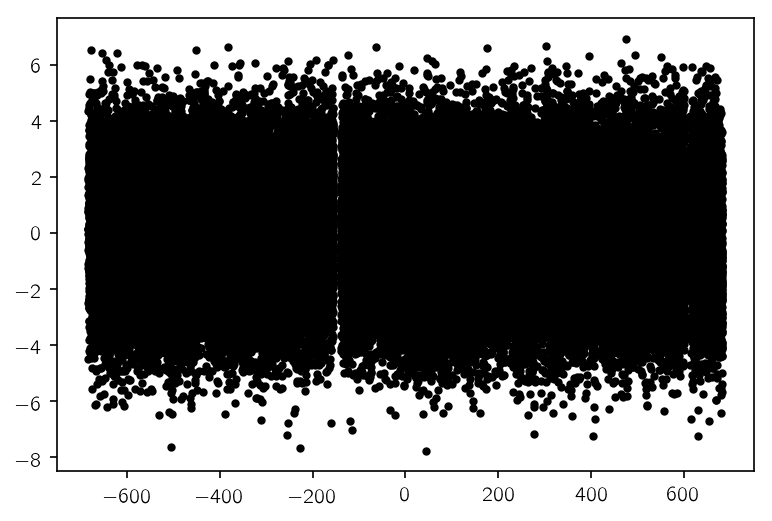

In [4]:
kicid = 9651065
metadata = np.loadtxt(f"data/kic{kicid}_metadata.csv", delimiter=",", skiprows=1)
nu_arr = metadata[::6]
times, mags = np.loadtxt(f"data/kic{kicid}_lc.txt",usecols=(0,1)).T

# Let's get rid of the crappy early data
start = 3000
times = times[start:]
mags = mags[start:]

# Subtract midpoint
time_mid = (times[0] + times[-1]) / 2.
times -= time_mid

nu_arr = np.loadtxt(f"data/kic{kicid}_metadata.csv", delimiter=",", skiprows=1)[::6]
nu_arr = nu_arr[:3]

mags *= 1000.

plt.plot(times, mags, ".k")

In [5]:
import theano.tensor as tt
import pymc3 as pm
from exoplanet.orbits import get_true_anomaly

nu_arr = np.array(nu_arr)

t = times
y = mags

with pm.Model() as model:
    # Parameters: Use normal priors when possible - Uniforms can be hard to sample
    logperiod = pm.Normal("logperiod", mu=np.log(272.), sd=100)
    period = pm.Deterministic("period", tt.exp(logperiod))
    t0 = pm.Normal("t0", mu=0.0, sd=100.0)
    varpi = xo.distributions.Angle("varpi")
#     varpi = pm.Normal("varpi", mu=0, sd=2*np.pi)
#     varpi_vec = pm.Normal("varpi_vec", shape=2, testval=np.array([1.0, 0.0]))
#     varpi = pm.Deterministic("varpi", tt.arctan2(varpi_vec[0], varpi_vec[1]))
    eccen = pm.Uniform("eccen", lower=1e-5, upper=1.0 - 1e-5, testval=0.1)
    logs = pm.Normal('logs', mu=np.log(np.std(y)), sd=100)
    lighttime = pm.Normal('lighttime', mu=0.0, sd=100.0, shape=len(nu_arr))
    
    # Better parameterization for the reference time
    # see: https://github.com/dfm/exoplanet/blob/master/exoplanet/orbits/keplerian.py
    sinw = tt.sin(varpi)
    cosw = tt.cos(varpi)
    opsw = 1 + sinw
    E0 = 2 * tt.arctan2(tt.sqrt(1-eccen)*cosw, tt.sqrt(1+eccen)*opsw)
    M0 = E0 - eccen * tt.sin(E0)
    tref = pm.Deterministic("tref", t0 - M0 * period / (2*np.pi))
    
    # Mean anom
    M = 2.0 * np.pi * (t - tref) / period

    # True anom
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    psi = - (1 - tt.square(eccen)) * tt.sin(f+varpi) / (1 + eccen*tt.cos(f))
    
    # tau in d
    tau = (lighttime / 86400.)[None,:] * psi[:,None]
    
    # Just sample in the weights parameters too. This seems to be faster
    factor = 2. * np.pi * nu_arr[None, :]
    arg = factor * t[:, None] - factor * tau
    mean_flux = pm.Normal("mean_flux", mu=0.0, sd=100.0)
    W_hat_cos = pm.Normal("W_hat_cos", mu=0.0, sd=100.0, shape=len(nu_arr))
    W_hat_sin = pm.Normal("W_hat_sin", mu=0.0, sd=100.0, shape=len(nu_arr))
    model_tensor = tt.dot(tt.cos(arg), W_hat_cos[:, None])
    model_tensor += tt.dot(tt.sin(arg), W_hat_sin[:, None])
    model_tensor = tt.squeeze(model_tensor) + mean_flux
        
    # Condition on the observations
    pm.Normal("obs", mu=model_tensor, sd=tt.exp(logs), observed=y)

In [6]:
# Let's be a little more clever about the optimization:
with model:
    map_soln = xo.optimize(start=model.test_point, vars=[mean_flux, W_hat_cos, W_hat_sin])
    map_soln = xo.optimize(start=map_soln, vars=[logs, mean_flux, W_hat_cos, W_hat_sin])
    map_soln = xo.optimize(start=map_soln, vars=[lighttime, t0])
    map_soln = xo.optimize(start=map_soln, vars=[logs, mean_flux, W_hat_cos, W_hat_sin])
    map_soln = xo.optimize(start=map_soln, vars=[logperiod, t0])
    map_soln = xo.optimize(start=map_soln, vars=[eccen, varpi])
    map_soln = xo.optimize(start=map_soln, vars=[logperiod, t0])
    map_soln = xo.optimize(start=map_soln, vars=[lighttime])
    map_soln = xo.optimize(start=map_soln, vars=[eccen, varpi])
    map_soln = xo.optimize(start=map_soln, vars=[logs, mean_flux, W_hat_cos, W_hat_sin])
    map_soln = xo.optimize(start=map_soln)

success: True
initial logp: -130902.1310546205
final logp: -113175.27939142798
success: False
initial logp: -113175.27939142798
final logp: -104362.73695588905
success: True
initial logp: -104362.73695588905
final logp: -102996.79986476515
success: True
initial logp: -102996.79986476515
final logp: -102951.4775872977
success: True
initial logp: -102951.4775872977
final logp: -102950.65441379999
success: True
initial logp: -102950.65441379999
final logp: -102947.02039482672
success: True
initial logp: -102947.02039482672
final logp: -102946.53069134353
success: True
initial logp: -102946.53069134353
final logp: -102946.5162696447
success: True
initial logp: -102946.5162696447
final logp: -102946.04514934646
success: False
initial logp: -102946.04514934646
final logp: -102943.2193472213
success: False
initial logp: -102943.2193472213
final logp: -102878.64452537594


In [7]:
map_soln

{'logperiod': array(5.60642971),
 't0': array(38.95174549),
 'varpi_angle__': array([-1.0985174 ,  0.89065146]),
 'eccen_interval__': array(-0.07997438),
 'logs': array(0.26553249),
 'lighttime': array([-178.269623  , -192.01068017, -186.01786912]),
 'mean_flux': array(-0.00033428),
 'W_hat_cos': array([ 1.44366202, -0.53827712,  0.44128811]),
 'W_hat_sin': array([ 1.32296982, -0.68167449, -0.58085033]),
 'period': array(272.17077399),
 'varpi': array(-0.88951915),
 'eccen': array(0.48001745),
 'tref': array(-32.12420257)}

Text(0, 0.5, 'Time delay (s)')

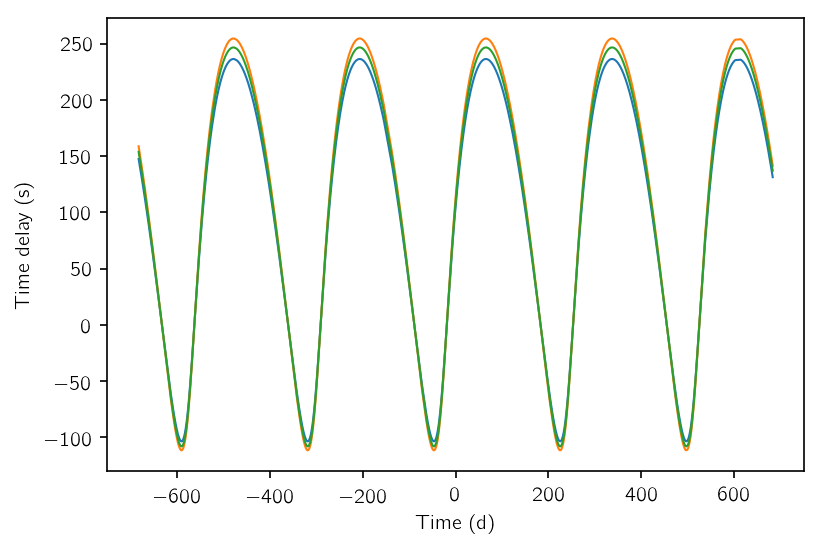

In [8]:
with model:
    tau_val = xo.utils.eval_in_model(tau, map_soln)
plt.plot(times, tau_val*86400-np.mean(tau_val), lw=1)
plt.xlabel('Time (d)')
plt.ylabel('Time delay (s)')

Text(0.5, 1.0, 'yup')

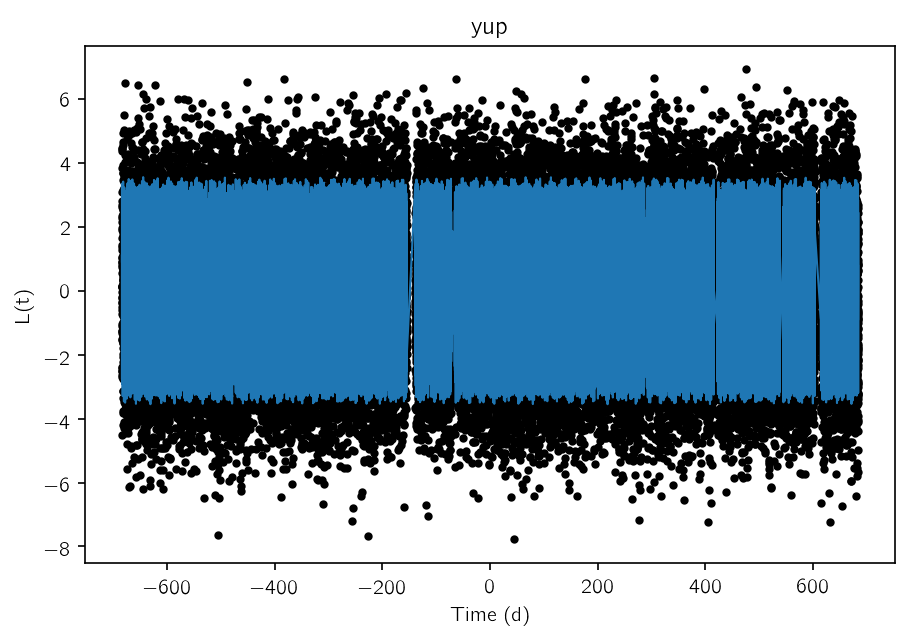

In [9]:
with model:
    lc_val = xo.utils.eval_in_model(model_tensor, map_soln)

plt.plot(times, mags, ".k")
plt.plot(times, lc_val, color="C0", lw=1)

plt.tight_layout()
# plt.xlim(0,5)
#plt.ylim(-1, 5)
plt.xlabel("Time (d)")
plt.ylabel("L(t)");
plt.title('yup')

In [10]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(start=50, window=50, finish=300)
with model:
    burnin = sampler.tune(tune=3000, start=map_soln,
                          step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 2 chains: 100%|██████████| 604/604 [05:10<00:00,  1.48draws/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [W_hat_sin, W_hat_cos, mean_flux, lighttime, logs, eccen, varpi, t0, logperiod]
Sampling 2 chains: 100%|██████████| 6000/6000 [50:04<00:00,  1.74draws/s]
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.


In [11]:
pm.summary(trace, varnames=["period", "lighttime", "t0", "varpi", "eccen", "logs", "mean_flux", "W_hat_cos", "W_hat_sin"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period,272.168521,0.500931,0.005620,271.203095,273.179785,6538.045872,0.999865
lighttime__0,-178.338625,4.981220,0.068334,-188.207974,-168.661719,4195.827281,1.000480
lighttime__1,-192.060363,8.695042,0.108005,-208.981921,-175.499736,4478.571575,0.999843
lighttime__2,-186.049275,7.531687,0.104777,-201.026878,-171.736701,4871.009281,0.999839
t0,39.044657,4.938009,0.092205,29.303490,48.504754,2373.057237,1.001260
varpi,-0.890857,0.073884,0.001696,-1.035035,-0.751290,1855.115245,1.001006
eccen,0.480325,0.035056,0.000517,0.413496,0.548927,4247.692961,1.000179
logs,0.265604,0.002939,0.000051,0.259822,0.271425,2839.336846,0.999863
mean_flux,-0.000290,0.005358,0.000072,-0.011105,0.009994,6600.638337,0.999857
W_hat_cos__0,1.443459,0.019862,0.000316,1.405308,1.482094,3667.185342,0.999857


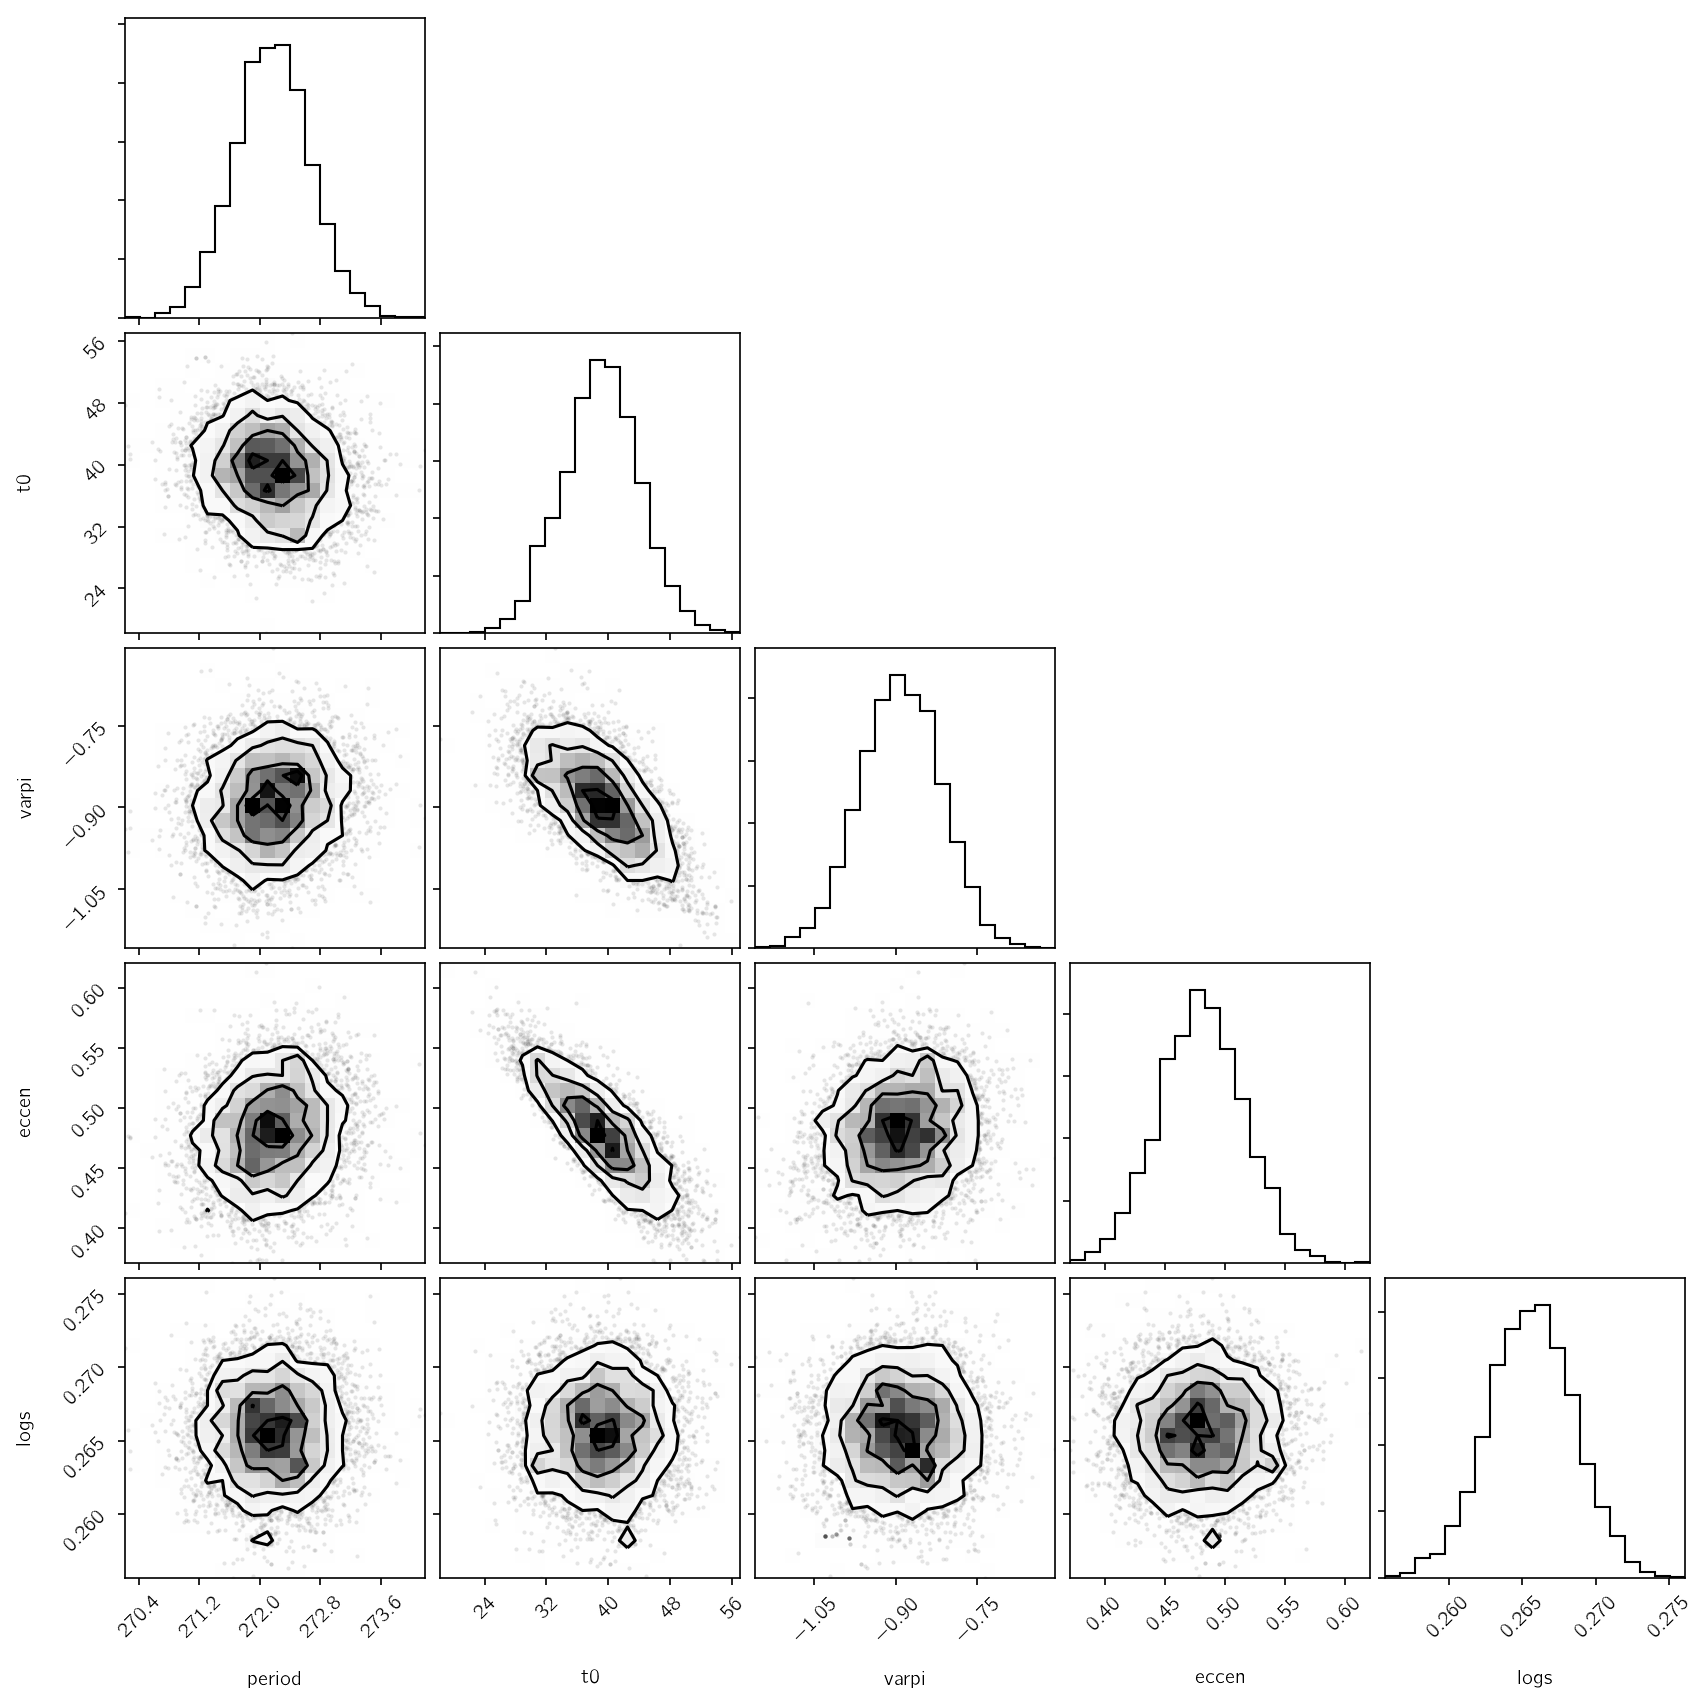

In [12]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["period", "t0", "varpi", "eccen", "logs"])
for k in samples.columns:
    if "_" in k:
        samples[k.replace("_", "")] = samples[k]
        del samples[k]
corner.corner(samples);